In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../k6/results/csr/'

def convert_to_MiB(value):
    if 'GiB' in value:
        return str(int(float(value.replace('GiB', '')) * 1024))
    if 'MiB' in value:
        return value.replace('MiB', '')
    if 'B' in value:
        return str(int(float(value.replace('B', '')) / 1024))
    return value

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

def graph_row(plot_func, dataset, features, height=3, width=20):
    cols = len(features)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, f in enumerate(features):
        plot_func(dataset, f, axes[x], idx=x)
    return plt

# 5.000 VUs

In [2]:
dirty_df = pd.read_csv(f'{path}5000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,discovery_cpu_percent,monolith_cpu_percent,cdn_mem_percent,discovery_mem_percent,monolith_mem_percent,cdn_mem_usage,discovery_mem_usage,monolith_mem_usage,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,35,0.00,0.00,103.51,0.26,0.23,35.37,20.43,18.21,2771.00,0.71,0.51,4.16,416,83.40,83.00,84.00,417.00,0.00,0.00
1,40,0.00,0.00,107.53,0.26,0.23,35.40,20.43,18.21,2774.00,0.70,0.51,1.82,417,83.20,83.00,84.00,416.00,0.00,0.00
2,45,0.00,0.00,114.77,0.26,0.23,35.62,20.43,18.21,2792.00,0.70,0.52,5.99,417,83.40,83.00,84.00,417.00,0.00,0.00
3,50,0.01,0.00,103.95,0.26,0.23,35.66,20.43,18.21,2794.00,0.70,0.52,4.07,416,83.40,83.00,84.00,417.00,0.00,0.00
4,60,0.00,0.00,118.62,0.26,0.23,35.91,20.43,18.21,2813.00,0.70,0.51,5.16,417,83.40,83.00,84.00,417.00,0.00,0.00
5,65,0.00,0.00,104.56,0.26,0.23,35.91,20.43,18.21,2814.00,0.68,0.51,4.59,416,83.40,83.00,84.00,417.00,0.00,0.00
6,70,0.00,0.00,106.25,0.26,0.23,35.96,20.43,18.21,2818.00,0.68,0.46,2.00,417,83.20,83.00,84.00,416.00,0.00,0.00
7,75,0.00,0.00,106.91,0.26,0.23,36.16,20.43,18.21,2833.00,0.67,0.52,2.13,417,83.40,83.00,84.00,417.00,0.00,0.00
8,80,0.00,0.01,103.39,0.26,0.23,36.13,20.43,18.21,2831.00,0.68,0.48,4.09,416,83.40,83.00,84.00,417.00,0.00,0.00
9,85,0.00,0.00,114.34,0.26,0.23,36.29,20.43,18.21,2843.00,0.66,0.44,1.58,417,83.20,83.00,84.00,416.00,0.00,0.00


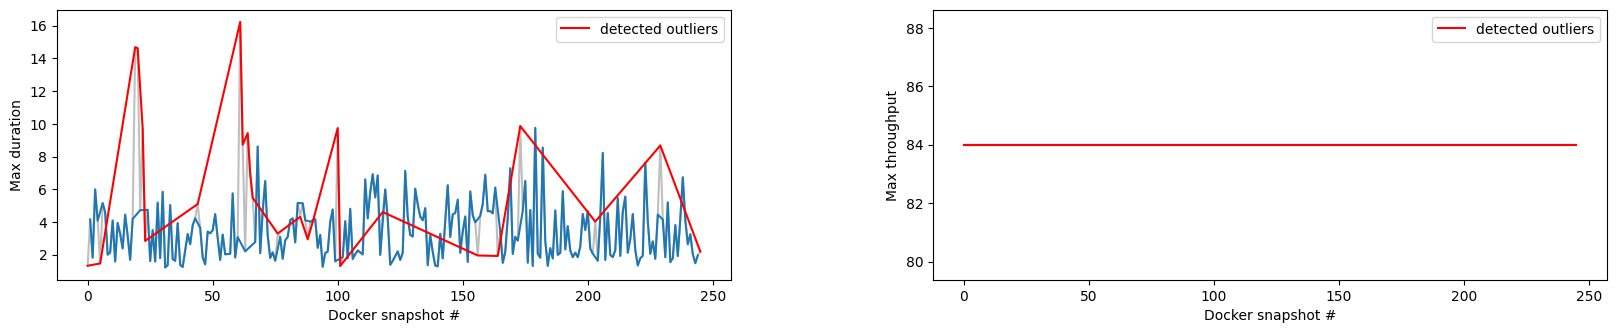

In [3]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

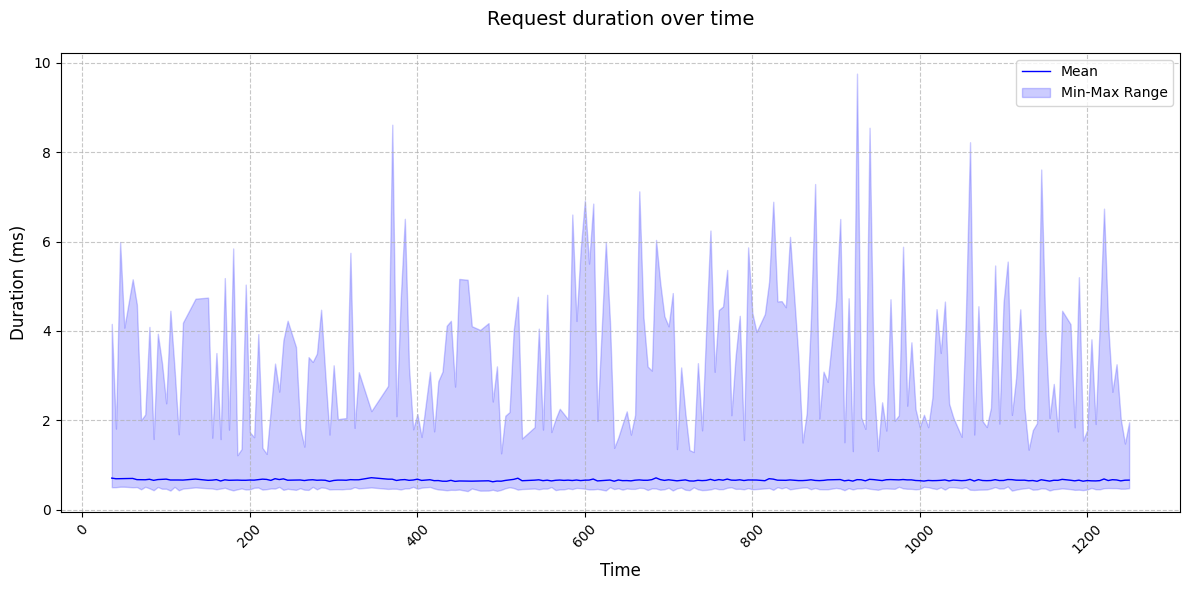

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

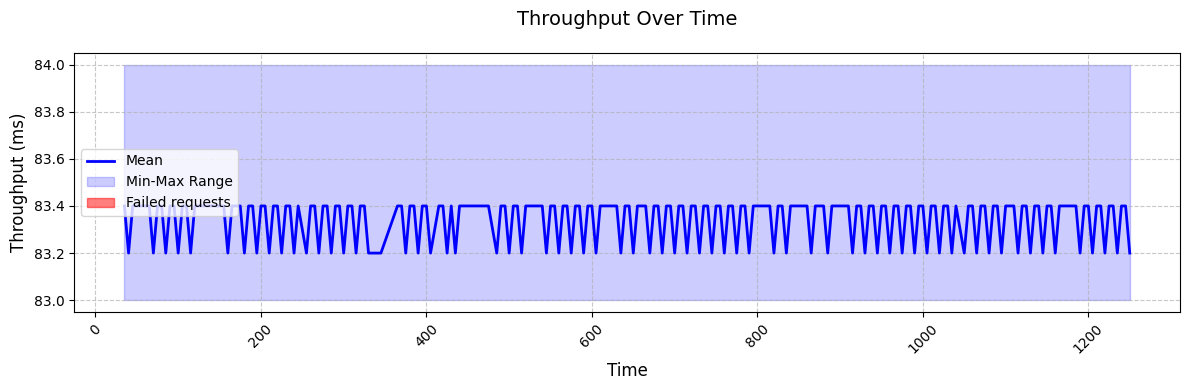

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

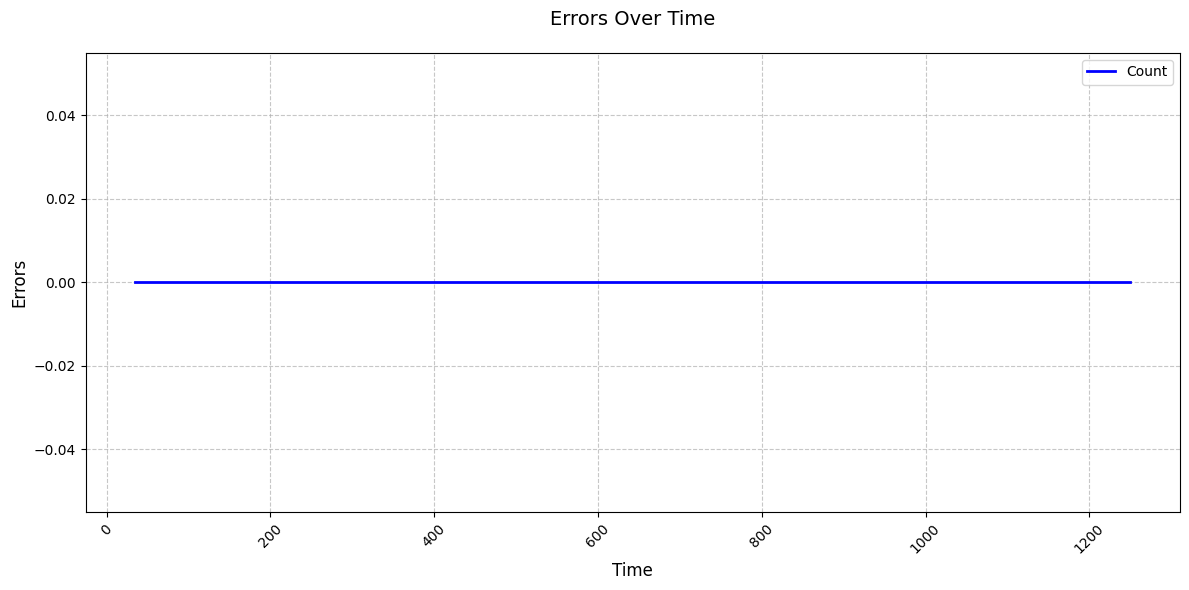

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 10.000 VUs

In [7]:
dirty_df = pd.read_csv(f'{path}10000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,discovery_cpu_percent,monolith_cpu_percent,cdn_mem_percent,discovery_mem_percent,monolith_mem_percent,cdn_mem_usage,discovery_mem_usage,monolith_mem_usage,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,30,0.00,0.00,120.28,0.23,0.23,35.09,17.83,17.70,2750.00,0.62,0.43,5.02,833,166.80,166.00,167.00,834.00,0.00,0.00
1,35,0.00,0.00,110.74,0.23,0.23,35.46,17.83,17.70,2779.00,0.60,0.41,4.12,833,166.60,166.00,167.00,833.00,0.00,0.00
2,40,0.00,0.00,105.73,0.23,0.23,35.52,17.83,17.70,2783.00,0.60,0.42,8.73,834,166.60,166.00,167.00,833.00,0.00,0.00
3,50,0.00,0.00,104.85,0.23,0.23,35.78,17.83,17.70,2804.00,0.60,0.40,5.39,833,166.60,166.00,167.00,833.00,0.00,0.00
4,55,0.00,0.00,105.50,0.23,0.23,35.96,17.83,17.70,2818.00,0.59,0.43,5.39,834,166.60,166.00,167.00,833.00,0.00,0.00
5,60,0.00,0.00,105.01,0.23,0.23,36.08,17.83,17.70,2827.00,0.63,0.45,5.52,833,166.80,166.00,167.00,834.00,0.00,0.00
6,65,0.00,0.00,107.54,0.23,0.23,36.19,17.83,17.70,2836.00,0.60,0.43,4.13,833,166.60,166.00,167.00,833.00,0.00,0.00
7,70,0.00,0.00,125.08,0.23,0.23,36.33,17.83,17.70,2847.00,0.59,0.42,5.67,834,166.60,166.00,167.00,833.00,0.00,0.00
8,75,0.00,0.00,105.78,0.23,0.23,36.47,17.83,17.70,2857.00,0.60,0.43,3.82,833,166.80,166.00,167.00,834.00,0.00,0.00
9,80,0.00,0.00,106.01,0.23,0.23,36.56,17.83,17.70,2865.00,0.61,0.46,5.52,833,166.60,166.00,167.00,833.00,0.00,0.00


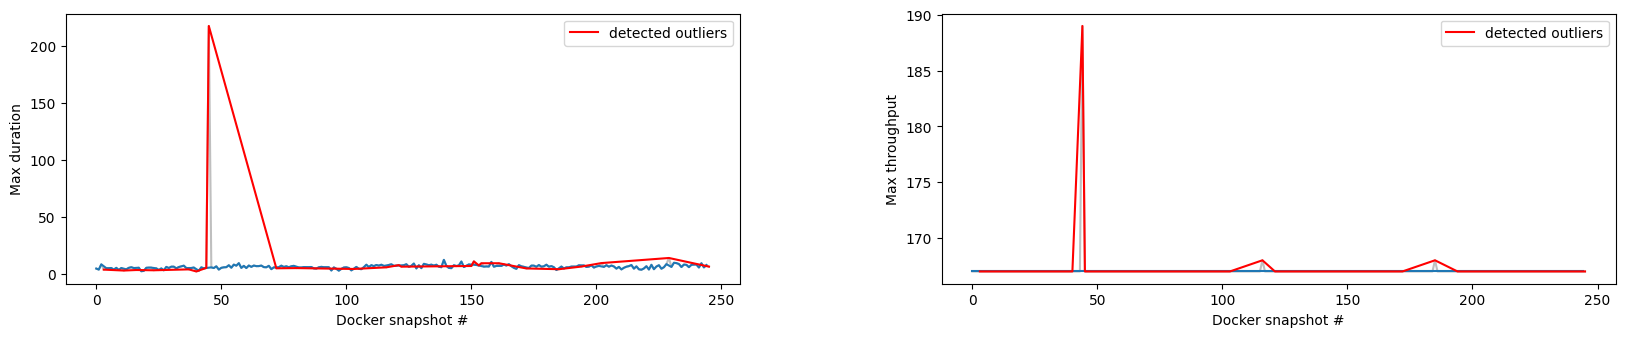

In [8]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

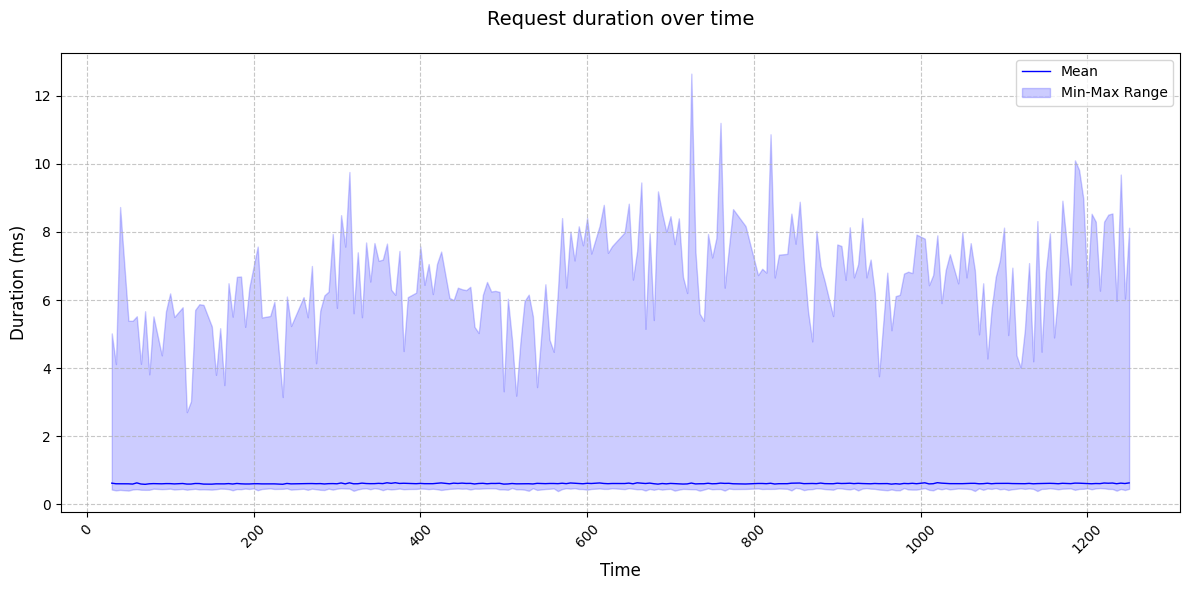

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

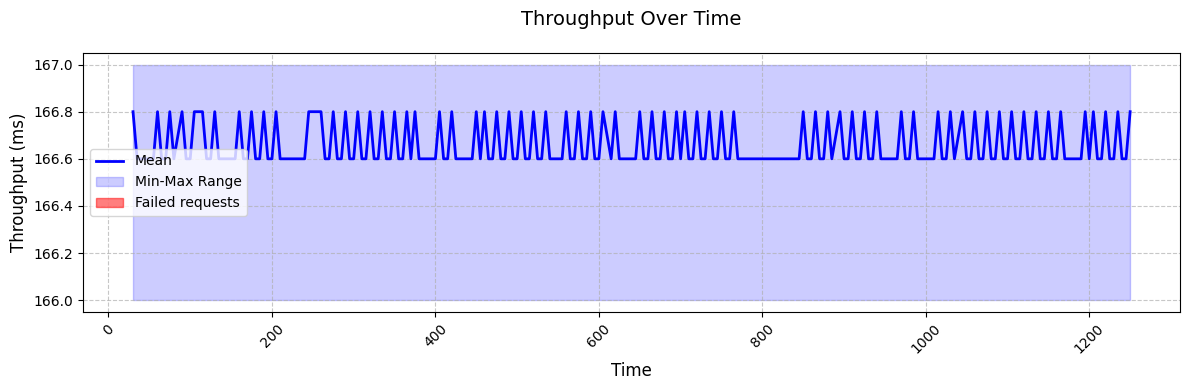

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

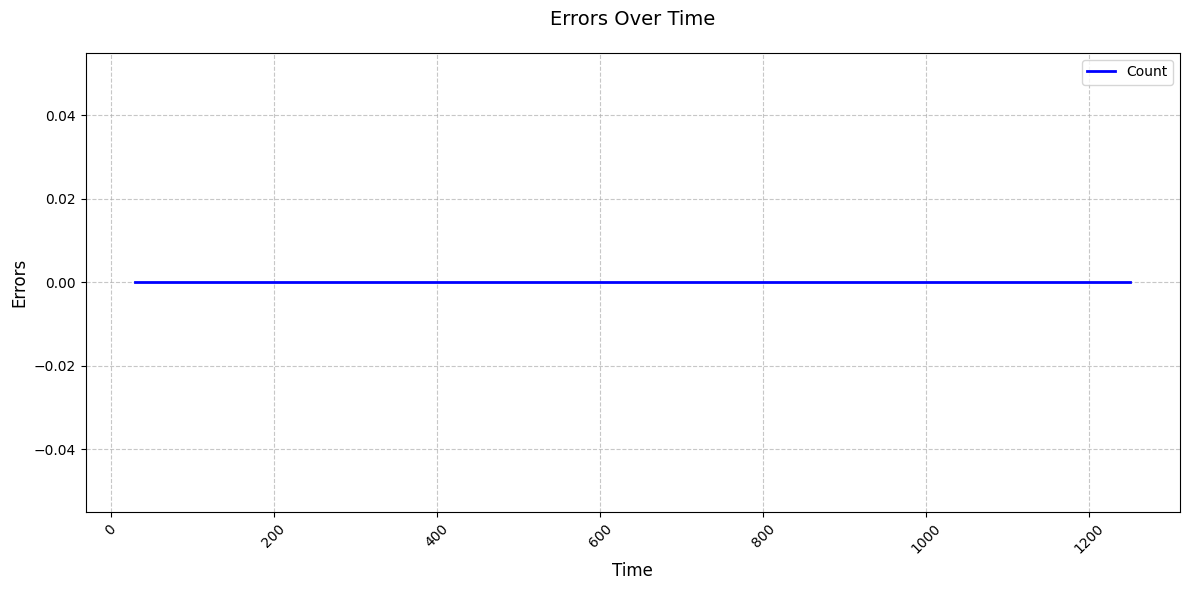

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()